In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os, math, cv2
import pandas as pd
from random import randint

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix as CMT
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, jaccard_score, classification_report

In [ ]:
# !pip install monai
# from monai.metrics import SurfaceDistanceMetric, compute_average_surface_distance, HausdorffDistanceMetric, compute_hausdorff_distance

In [ ]:
%%capture
!pip install pkbar
import pkbar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path='/content/drive/My Drive/Major Project AutoSLIDE'
if os.getcwd() is not path:
  os.chdir(path)

Mounted at /content/drive


In [ ]:
from mi_unet3d import *
from utils import *
from dataset import *

In [ ]:
volume_shape = [120, 120, 120]
device= "cuda" if torch.cuda.is_available() else "cpu"
print(device)
load = 0
check_pt_file = 'weights/dummy_after62epochs.pth.tar'
check_pt_file_load = 'weights/dummy_after51epochs.pth.tar'
load = 1
batch_size = 4
learning_rate = 1e-4
num_epochs = 100

cuda


In [ ]:
train_loader = DataLoader(MI_Dataset(csv_path = 'directory_train.csv', patch_shape = volume_shape, sampling_mode='random', deterministic=True),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MI_Dataset(csv_path = 'directory_val.csv', patch_shape = volume_shape, sampling_mode='center_val', deterministic=True),
                        batch_size=batch_size, shuffle=True)

torch.Size([4, 2, 120, 120, 120]) torch.Size([4, 1, 120, 120, 120])
tensor(1.) tensor(0.) tensor(5835168.)
tensor(1.) tensor(0.) tensor(72940.)
95


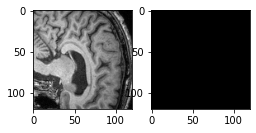

In [ ]:
image, mask = next(iter(val_loader))
print(image.shape, mask.shape)
print(image.max(), image.min(), image.sum())
print(mask.max(), mask.min(), mask.sum())
i = randint(0, volume_shape[0]-1)
print(i)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image[0,0,i], 'gray')
plt.subplot(1,2,2)
plt.imshow(mask[0,0,i], 'gray')
plt.show()

In [ ]:
model = MI_UNET(in_channels=2, out_channels=1).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
LOSS = DiceBCELoss(weights=[0.5, 0.5])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader), verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [ ]:
summary(model, input_size=(2,120,120,120), batch_size = batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [4, 32, 120, 120, 120]           1,728
       BatchNorm3d-2     [4, 32, 120, 120, 120]              64
              ReLU-3     [4, 32, 120, 120, 120]               0
            Conv3d-4     [4, 32, 120, 120, 120]          27,648
       BatchNorm3d-5     [4, 32, 120, 120, 120]              64
              ReLU-6     [4, 32, 120, 120, 120]               0
        DoubleConv-7     [4, 32, 120, 120, 120]               0
         MaxPool3d-8        [4, 32, 60, 60, 60]               0
            Conv3d-9        [4, 64, 60, 60, 60]          55,296
      BatchNorm3d-10        [4, 64, 60, 60, 60]             128
             ReLU-11        [4, 64, 60, 60, 60]               0
           Conv3d-12        [4, 64, 60, 60, 60]         110,592
      BatchNorm3d-13        [4, 64, 60, 60, 60]             128
             ReLU-14        [4, 64, 60,

In [ ]:
if load:
  model, optimizer = load_checkpoint(model, optimizer, check_pt_file_load, device=device)
  print('Model loaded.')
  print('Loaded optimizer:', optimizer)
  print('Loaded checkpoint:', check_pt_file_load)
else:
  print('Training starting afresh.')
print('Saving checkpoint:', check_pt_file)

Model loaded.
Loaded optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 4.857886086178193e-05
    weight_decay: 0
)
Loaded checkpoint: weights/dummy_after51epochs.pth.tar
Saving checkpoint: weights/dummy_after62epochs.pth.tar


In [ ]:
def train():
  train_per_epoch = len(train_loader)
  val_per_epoch = len(val_loader)
  # min_loss = math.inf
  min_loss=0.1588

  global_train_losses=[]
  global_val_losses=[]
  global_train_dcs=[]
  global_val_dcs=[]

  for epoch in range(num_epochs):
    train_losses = []
    train_dcs = []
    kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
      data = data.to(device=device)
      targets = targets.to(device=device)
      
      scores = model(data)
      train_loss = LOSS(scores, targets)
      train_losses.append(train_loss.item())
      
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      train_dc = dice_coef(scores, targets)
      train_dcs.append(train_dc.item())
      train_bce = bce_loss(scores, targets)
      train_hd = batch_HD(scores.cpu().detach().numpy(), targets.cpu().numpy())
      kbar_train.update(batch_idx+1, values=[("loss", train_loss.item()), ("dice score", train_dc.item()), ("bce loss", train_bce.item()),
                                             ("hd", train_hd.item())])
    
    mean_train_loss = np.mean(train_losses)
    mean_train_dc = np.mean(train_dcs)
    global_train_losses.append(mean_train_loss)
    global_train_dcs.append(mean_train_dc)
    print()

    val_losses = []
    val_dcs = []
    kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
    with torch.no_grad():
      model.eval()
      for batch_idx, (data, targets) in enumerate(val_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        val_loss = LOSS(scores, targets)
        val_losses.append(val_loss.item())

        val_dc = dice_coef(scores, targets)
        val_dcs.append(val_dc.item())
        val_bce = bce_loss(scores, targets)
        val_hd = batch_HD(scores.cpu().detach().numpy(), targets.cpu().numpy())
        kbar_val.update(batch_idx+1, values=[("val loss", val_loss.item()), ("val dice score", val_dc.item()), ("val bce loss", val_bce.item()),
                                             ("val hd", val_hd.item())])
      
      mean_val_loss = np.mean(val_losses)
      mean_val_dc = np.mean(val_dcs)
      global_val_losses.append(mean_val_loss)
      global_val_dcs.append(mean_val_dc)

      scheduler.step()

      if mean_val_loss < min_loss:
        min_loss = mean_val_loss
        print('\nImproved validation loss: {:.4f}'.format(min_loss))
        save_checkpoint(model, optimizer, check_pt_file)
        print('Model saved to {}'.format(check_pt_file))

        df = pd.DataFrame(columns=['train loss', 'val loss', 'train dice score', 'val dice score'])
        df['train loss']= global_train_losses
        df['val loss']= global_val_losses
        df['train dice score']= global_train_dcs
        df['val dice score']= global_val_dcs
        df.to_csv('plots_miunet_dummy_after62epochs.csv')
      print()

In [ ]:
train()

Epoch: 1/100
102/102 [==============================] - 1358s 13s/step - loss: 0.1748 - dice score: 0.6663 - bce loss: 0.0159 - hd: 11.1949

Epoch: 1/100
20/20 [==============================] - 223s 11s/step - val loss: 0.1943 - val dice score: 0.6473 - val bce loss: 0.0358 - val hd: 13.5287
Adjusting learning rate of group 0 to 4.8567e-05.

Epoch: 2/100
102/102 [==============================] - 608s 6s/step - loss: 0.1582 - dice score: 0.6976 - bce loss: 0.0139 - hd: 10.1975

Epoch: 2/100
20/20 [==============================] - 85s 4s/step - val loss: 0.2001 - val dice score: 0.6353 - val bce loss: 0.0355 - val hd: 13.8504
Adjusting learning rate of group 0 to 4.8533e-05.

Epoch: 3/100
102/102 [==============================] - 607s 6s/step - loss: 0.1665 - dice score: 0.6822 - bce loss: 0.0151 - hd: 10.7602

Epoch: 3/100
20/20 [==============================] - 85s 4s/step - val loss: 0.1880 - val dice score: 0.6608 - val bce loss: 0.0368 - val hd: 16.0409
Adjusting learning rate 